![portada](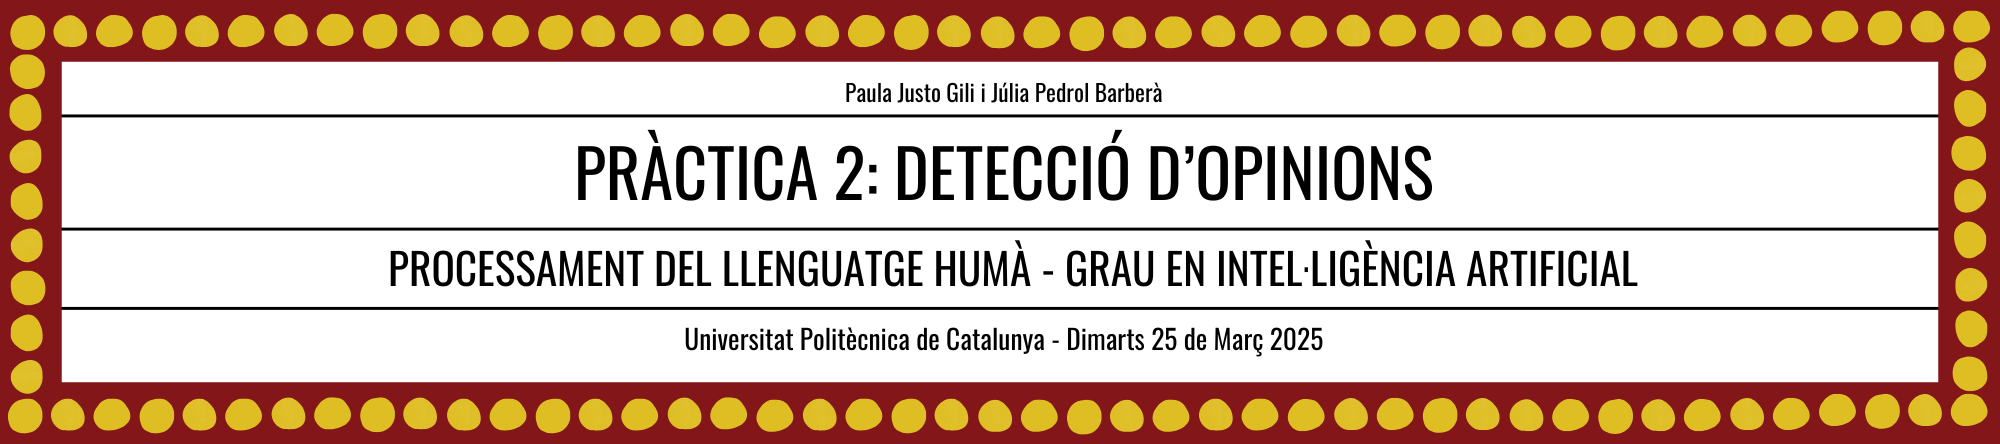
)

## **ÍNDEX**
- [INTRODUCCIÓ](#introducció)
- [LECTURA DE DADES](#lectura-de-dades)
- [PARTICIÓ EN TRAIN I TEST](#partició-en-train-i-test)
- [LEMATITZACIÓ](#lematització)
    - [1. POS Tagging](#1-pos-tagging)
    - [2. Lematització dels textos](#2-lematització-dels-textos)
- [PREPROCESSAT](#preprocessat)
- [PART SUPERVISADA](#part-supervisada)
    - [Vectorització del textamb CountVectorizer](#vectorització-del-text-amb-countvectorizer)
    - [Entrenament dels models supervisats](#entrenament-dels-models-supervisats)
        - [1. Multinomial Naive Bayes](#1-multinomial-naive-bayes)
        - [2. Random Forest](#2-random-forest)
        - [3. Regressió Logística](#3-regressió-logística)
        - [4. SVM (Support Vector Machine)](#4-svm-support-vector-machine)
        - [Comparació dels models amb la Corba de ROC](#comparació-de-models-amb-la-corba-roc)
        - [Selecció del millor model](#selecció-del-millor-model)
        - [Conclusió primera part](#conclusió-primera-part)
- [PART NO SUPERVISADA](#part-no-supervisada)
    - [Explicació del funcionament](#explicació-del-funcionament)
- [COMPARACIÓ MODEL SUPERVISAT I NO SUPERVISAT](#comparació-model-supervisat-i-no-supervisat)
- [ANÀLISI DELS ERRORS](#anàlisi-dels-errors)
- [CONCLUSIONS GENERALS](#conclusions-generals)

## **INTRODUCCIÓ**
---

En aquesta pràctica abordarem la detecció automàtica d’opinions positives o negatives en crítiques de pel·lícules. El treball es troba dividit en dues parts.

**En la primera** implementarem diversos models **d’aprenentatge supervisat** utilitzant el corpus Movie Reviews. Aplicarem tècniques de preprocessament, representarem els textos amb el CountVectorizer i entrenarem diversoso model de classificació per predir la polaritat de les opinions. També definirem un protocol de validació i analitzarem quin dels models ens proporciona una millor classificació, comparant la seva precisió i la matriu de confusió corresponent.

**Mentre que en la segona,** treballarem amb un **enfocament no supervisat.** Utilitzarem el desambiguador Lesk per obtenir els synsets de les paraules i consultarem el SentiWordNet per obtenir-ne els valors de polaritat. Ens plantejarem com combinar aquests valors, per determinar si el text expressa una opinió positiva o negativa, i provarem diferents combinacions de categories gramaticals (adjectius, noms, verbs, adverbis). 

Finalment, compararem els resultats d’aquesta estratègia no supervisada amb els obtinguts en la part supervisada i analitzarem els errors que s'han comés en les deteccions d'opinió (tant en la part supervisada com en la no supervisada).

## **LECTURA DE DADES**
---

In [1]:
%pip install --user -U nltk
%pip install --user -U numpy
%pip install svgling

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk
nltk.download('movie_reviews')
nltk.download('stopwords')
from nltk.corpus import movie_reviews as mr
from nltk.corpus import stopwords

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/paula/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/paula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Baixar recursos necessaris
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/paula/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/paula/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/paula/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/paula/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
file_ids = mr.fileids()
print(f"\033[1mTotal de ressenyes:\033[0m {len(file_ids)}")  # 2000 ressenyes (1000 pos, 1000 neg)

Total de ressenyes: 2000


In [5]:
# Veure els identificadors dels documents
print("\033[1mPrimeres 5 ressenyes (nom de l'arxiu):\033[0m")
print(mr.fileids()[:5])

# Veure les categories (positives o negatives)
print("\n\033[1mCategories disponibles:\033[0m")
print(mr.categories())

# Veure una ressenya concreta (primer document)
print("\n\033[1mContingut del primer document (paraules):\033[0m")
print(mr.words(mr.fileids()[0])[:50])  # Mostrem només 50 paraules per veure què conté


Primeres 5 ressenyes (nom de l'arxiu):
['neg/cv000_29416.txt', 'neg/cv001_19502.txt', 'neg/cv002_17424.txt', 'neg/cv003_12683.txt', 'neg/cv004_12641.txt']

Categories disponibles:
['neg', 'pos']

Contingut del primer document (paraules):
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.', 'they', 'get', 'into', 'an', 'accident', '.', 'one', 'of', 'the', 'guys', 'dies', ',', 'but', 'his', 'girlfriend', 'continues', 'to', 'see', 'him', 'in', 'her', 'life', ',', 'and', 'has', 'nightmares', '.', 'what', "'", 's', 'the', 'deal', '?', 'watch']


## **PARTICIÓ EN TRAIN I TEST**
---

Al principi vam considerar de dividir les dades en **train**, **validation** i **test**, però al final vam veure que no valia la pena, ja que quan utilitzem el `GridSearchCV` per entrenar els models supervisats, aquest ja fa una validació interna per provar diferents combinacions d’hiperparàmetres i escollir la millor. És a dir, ja fa ell sol una mena de partició entre train i validation.

Per això, només fem una **partició entre train i test**, la qual ens serveix per entrenar el model i després avaluar-ne el rendiment. A més, utilitzem una partició estratificada, que manté la proporció de classes (positives i negatives) tant al train com al test. Fer aquesta partició estratificada és important perquè el model mostri una distribució semblant de dades en els dos conjunts.

In [6]:
from sklearn.model_selection import train_test_split

# Obtenir les etiquetes de cada document
etiquetes = [mr.categories(file_id)[0] for file_id in file_ids]

# Fer la partició estratificada
train_ids, test_ids = train_test_split(
    file_ids,
    test_size=0.2,
    random_state=123,
    stratify=etiquetes 
)

print(f"\033[1mTrain: {len(train_ids)} documents, Test: {len(test_ids)} documents\033[0m\n")

train_etiquetes = [mr.categories(file_id)[0] for file_id in train_ids]
test_etiquetes = [mr.categories(file_id)[0] for file_id in test_ids]
print(f"Train → Positius: {train_etiquetes.count('pos')}, Negatius: {train_etiquetes.count('neg')}")
print(f"Test  → Positius: {test_etiquetes.count('pos')}, Negatius: {test_etiquetes.count('neg')}")


Train: 1600 documents, Test: 400 documents

Train → Positius: 800, Negatius: 800
Test  → Positius: 200, Negatius: 200


In [7]:
# Obtenim els textos de cada conjunt
train_texts = [" ".join(mr.words(file_id)) for file_id in train_ids]
test_texts = [" ".join(mr.words(file_id)) for file_id in test_ids]

## **LEMATITZACIÓ**
---

### **1. POS tagging**

Abans de poder fer la lematització dels textos, necessitem saber quina categoria gramatical té cada paraula (si és un verb, un nom, un adjectiu...). Això és important perquè el lematitzador necessita aquesta informació per saber com transformar cada paraula a la seva forma base.

Per aconseguir això, fem **POS tagging** (Part-of-Speech tagging). Utilitzem la funció `pos_tag` de NLTK. La qual primer el que fa és tokenitzar el text per després poder retornar els pos_tags de cada token.

Un cop tenim això, apliquem el POS tagging tant al conjunt de train com al de test, ja que després haurem de lematitzar tots dos de la mateixa manera.

In [8]:
from nltk import pos_tag, word_tokenize

def obtenir_postags(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return pos_tags

In [9]:
# Aplicar POS tagging als textos de train i test
train_pos_tags = [obtenir_postags(text) for text in train_texts]
test_pos_tags = [obtenir_postags(text) for text in test_texts]

print("\033[1mExemple POS Train:\033[0m", train_pos_tags[0][:500])  
print("\033[1mExemple POS Test:\033[0m", test_pos_tags[0][:500])


Exemple POS Train: [('capsule', 'NN'), (':', ':'), ('the', 'DT'), ('much', 'RB'), ('anticipated', 'VBN'), ('re', 'NN'), ('-', ':'), ('adaptation', 'NN'), ('of', 'IN'), ('the', 'DT'), ('pierre', 'NN'), ('boulle', 'NN'), ('novel', 'NN'), ('comes', 'VBZ'), ('to', 'TO'), ('the', 'DT'), ('screen', 'NN'), ('as', 'IN'), ('a', 'DT'), ('dark', 'NN'), ('and', 'CC'), ('a', 'DT'), ('little', 'JJ'), ('dreary', 'JJ'), ('film', 'NN'), ('with', 'IN'), ('lots', 'NNS'), ('of', 'IN'), ('chases', 'NNS'), ('and', 'CC'), ('fighting', 'NN'), (',', ','), ('but', 'CC'), ('very', 'RB'), ('little', 'JJ'), ('intelligence', 'NN'), ('.', '.'), ('visually', 'RB'), ('there', 'EX'), ('is', 'VBZ'), ('much', 'RB'), ('to', 'TO'), ('like', 'VB'), ('about', 'IN'), ('this', 'DT'), ('version', 'NN'), (',', ','), ('but', 'CC'), ('the', 'DT'), ('approach', 'NN'), ('is', 'VBZ'), ('to', 'TO'), ('take', 'VB'), ('an', 'DT'), ('adventure', 'NN'), ('after', 'IN'), ('the', 'DT'), ('style', 'NN'), ('of', 'IN'), ('gulliver', 'NN'), ("'

### **2. Lematització dels textos**

Ara que ja tenim les paraules etiquetades amb la seva categoria gramatical (noms, verbs, adjectius ...), podem passar a fer la **lematització**. Amb la lematització bàsicament el que fem és reduir cada paraula a la seva forma base. Per exemple, si tenim el verb *"running"*, la idea és convertir-lo a *"run"*. D'aquesta forma aconseguim agrupar totes les formes d'una mateixa paraula i treure soroll al text.

Per fer-ho, fem servir el lematitzador de NLTK (`WordNetLemmatizer`). Per tal que el lematitzador sapigui quin tipus de paraula està tractant, hem creat un diccionari (`pos_dict`) que transforma les etiquetes del POS tagging al format que entén el lematitzador.

Un cop tenim això, li passem cada paraula amb el seu POS tag i obtenim el seu lema. Això ho fem per tots els textos de train i de test, perquè així tot el corpus queda lematitzat de la mateixa manera.

In [10]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Inicialitzar el lematitzador
wnl = WordNetLemmatizer()

# Diccionari per convertir els POS tags de NLTK a WordNet
pos_dict = {
    'NN': wordnet.NOUN, 'NNS': wordnet.NOUN, 'NNP': wordnet.NOUN, 'NNPS': wordnet.NOUN,
    'JJ': wordnet.ADJ, 'JJR': wordnet.ADJ, 'JJS': wordnet.ADJ,
    'VB': wordnet.VERB, 'VBD': wordnet.VERB, 'VBG': wordnet.VERB, 'VBN': wordnet.VERB,
    'VBP': wordnet.VERB, 'VBZ': wordnet.VERB,
    'RB': wordnet.ADV, 'RBR': wordnet.ADV, 'RBS': wordnet.ADV
}

# Funció per lematitzar una paraula amb el seu POS tag
def lemmatize(word, pos_tag):
    pos = pos_dict.get(pos_tag, wordnet.NOUN)
    return wnl.lemmatize(word, pos)


In [11]:
# Aplicar lematització als textos de train i test
train_texts_lem = [" ".join(lemmatize(word, tag) for word, tag in train_pos_tags[i]) for i in range(len(train_pos_tags))]
test_texts_lem = [" ".join(lemmatize(word, tag) for word, tag in test_pos_tags[i]) for i in range(len(test_pos_tags))]

print("\033[1mExemple de text lematitzat (Train):\033[0m", train_texts_lem[0][:500])
print("\033[1mExemple de text lematitzat (Test):\033[0m", test_texts_lem[0][:500])

Exemple de text lematitzat (Train): capsule : the much anticipate re - adaptation of the pierre boulle novel come to the screen a a dark and a little dreary film with lot of chase and fighting , but very little intelligence . visually there be much to like about this version , but the approach be to take an adventure after the style of gulliver ' s travel and treat it a an action film . that make it a film without much center . , 0 ( - 4 to + 4 ) pierre boulle , author of the bridge on the river kwai , write planet of the ape ( a 
Exemple de text lematitzat (Test): country and legal system that take the rule of law principle seriously , have forbid judge and jury to make judgement in all matter that could involve them personally . luckily , movie reviewer aren ' t burden with such legislation . otherwise , small pool of very special movie would be forever ignore by this reviewer . in case of star war , 1977 science fiction epic by george lucas , the consequence would be even more sever

## **PREPROCESSAT**
---
Abans d’entrenar cap model, cal netejar el text perquè els algoritmes treballin només amb la informació rellevant. En el nostre cas, hem aplicat una sèrie de passos de preprocessament als dos conjunts de dades (train i test).

Els passos que hem fet pel preprocessat són:

1. **Eliminar dígits**: hem tret tots els números del text, ja que normalment no aporten gaire valor en aquest tipus d’anàlisi.
2. **Convertir el text a minúscules**: així evitem comptar la mateixa paraula dues vegades només perquè una comença amb majúscula i l’altra no.
3. **Eliminar signes de puntuació**: també els hem tret perquè no tenen significat semàntic per al model i poden distorsionar l’anàlisi.

Un cop aplicat aquest preprocessat, hem passat al següent pas:

4. **Eliminar les stopwords**: aquestes són paraules molt freqüents com *"the"*, *"is"*, *"and"*, que no aporten gaire informació útil per al model. Les hem eliminat utilitzant la llista de stopwords per defecte de la llibreria nltk.

Aquestes transformacions s’han aplicat tant al conjunt de **train** com al de **test**, per mantenir la coherència entre els dos.

In [12]:
import string

# Funció per eliminar dígits
def elimina_digits(text):
    text_sense_digits = ''.join([char for char in text if not char.isdigit()])
    return text_sense_digits

# Funció per convertit tot el text en minuscules
def converteix_minuscules(text):
    text_minuscules = text.lower()
    return text_minuscules

# Funció per eliminar els signes de puntuació del text
def elimina_puntuacio(text):
    text_sense_puntuacio = ''.join([char for char in text if char not in string.punctuation])
    return text_sense_puntuacio

In [13]:
# Apliquem eliminació de dígits, puntuació i conversió a minúscules
train_texts = [converteix_minuscules(elimina_puntuacio(elimina_digits(text))) for text in train_texts_lem]
test_texts = [converteix_minuscules(elimina_puntuacio(elimina_digits(text))) for text in test_texts_lem]

In [14]:
# Funció per eliminar stopwords
def remove_stopwords_with_list(text, stopword_list):
    words = text.split()
    filtered_text = [word for word in words if word.lower() not in stopword_list]  
    return " ".join(filtered_text)


In [15]:
# Identificar les stopwords eliminades
all_stopwords = set(stopwords.words('english')) 
train_texts_clean = [remove_stopwords_with_list(text, all_stopwords) for text in train_texts]
test_texts_clean = [remove_stopwords_with_list(text, all_stopwords) for text in test_texts]

print("\033[1mExemple Train (Original):\033[0m", train_texts[0][:500])
print("\033[1mExemple Train (Sense stopwords):\033[0m", train_texts_clean[0][:500])

print("\n\033[1mExemple Test (Original):\033[0m", test_texts[0][:500])
print("\033[1mExemple Test (Sense stopwords):\033[0m", test_texts_clean[0][:500])

Exemple Train (Original): capsule  the much anticipate re  adaptation of the pierre boulle novel come to the screen a a dark and a little dreary film with lot of chase and fighting  but very little intelligence  visually there be much to like about this version  but the approach be to take an adventure after the style of gulliver  s travel and treat it a an action film  that make it a film without much center       to    pierre boulle  author of the bridge on the river kwai  write planet of the ape  a  k  a  monkey plane
Exemple Train (Sense stopwords): capsule much anticipate adaptation pierre boulle novel come screen dark little dreary film lot chase fighting little intelligence visually much like version approach take adventure style gulliver travel treat action film make film without much center pierre boulle author bridge river kwai write planet ape k monkey planet novel social satire read lot like fifth book gulliver travel human discover planet role ape human reverse unlike role

## **PART SUPERVISADA**
---

### **Vectorització del text amb CountVectorizer**

Un cop tenim els textos nets (sense digits, ni puntuació, ni stopwords...), el següent pas és convertir-los en una representació numèrica perquè els models els puguin entendre. Per fer això hem utilitzat el `CountVectorizer` de `sklearn`.

A l’hora de configurar el `CountVectorizer`, hem escollit uns paràmetres concrets pensant sobretot en **evitar el sobreajustament** i fer que el model generalitzi millor. 

La configuració ha estat la següent:

- `max_features=2000` → limitem el nombre de característiques a les 2000 més informatives. D’aquesta manera reduïm la complexitat del model i evitem tenir una matriu gegant amb milers de paraules que potser només surten un cop i no aporten res.
  
- `min_df=10` → només incloem paraules que apareixen en mínim 10 documents. Això ens permet filtrar soroll i paraules molt rares o molt específiques, que poden fer que el model s’ajusti massa als exemples concrets.

- `ngram_range=(1, 2)` → hem inclòs unigrams i bigrams perquè, a més de paraules individuals, també volem tenir en compte combinacions que poden donar més context (per exemple, “not good” és molt diferent de “good” sol). Això ajuda a captar una mica més de significat, però sense afegir massa complexitat.

- `binary=True` → en lloc de comptar quantes vegades surt una paraula, només mirem si apareix o no. Això ho fem perquè ens interessa més la presència de certs mots que no pas la seva repetició, i a més ens ajuda a reduir l’impacte de documents molt llargs.

En resum, hem triat aquests valors buscant un equilibri entre captar la informació útil i no passar-nos de detall, per evitar el típic problema del sobreajustament i aconseguir que el model funcioni bé amb dades noves.

Després de fer aquesta vectorització, hem convertit les matrius (que crea aquest mètode) a DataFrame per visualitzar millor el resultat (també per poder veure la matriu al complet l'hem guardat en un fitxer .csv).

Cal mencionar que inicialment vam provar de fer una reducció de dimensionalitat amb PCA, després de la vectorització, però els resultats van empitjorar força. A més, com amb `max_features` ja podíem controlar una mica la mida de la matriu i evitar que fos massa gran vam decidir no aplicar el PCA i optimitzar només aquest paràmetre del `CountVectorizer`.

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Vectoritzar el text
vectorizer = CountVectorizer(max_features=2000, min_df=10, ngram_range=(1, 2), stop_words=None, binary=True)
X_train = vectorizer.fit_transform(train_texts_clean).toarray()
X_test = vectorizer.transform(test_texts_clean).toarray()

# Convertir a DataFrame per veure millor la matriu
df_train = pd.DataFrame(X_train, columns=vectorizer.get_feature_names_out())
df_test = pd.DataFrame(X_test, columns=vectorizer.get_feature_names_out())

# Mostrar la matriu completa de Train
print("\033[1mMatriu de Train:\033[0m")
print(df_train)

# Mostrar la dimensió de la matriu
print("\n\033[1mDimensions de les matrius:\033[0m")
print(f"Train: {df_train.shape}, Test: {df_test.shape}")

# Guardar la matriu en un fitxer .csv
df_train.to_csv("matriu_countvectorizer.csv", index=False)
print("\nMatriu guardada com a 'matriu_countvectorizer.csv'.")


Matriu de Train:
      abandon  ability  able  absolutely  absurd  academy  academy award  \
0           0        0     0           0       0        0              0   
1           0        0     0           0       0        0              0   
2           0        0     0           0       0        0              0   
3           0        0     0           1       0        0              0   
4           0        0     0           0       0        0              0   
...       ...      ...   ...         ...     ...      ...            ...   
1595        0        0     0           0       0        0              0   
1596        0        0     1           0       0        0              0   
1597        0        0     1           0       0        0              0   
1598        0        0     0           0       0        0              0   
1599        0        1     0           0       0        0              0   

      accent  accept  accident  ...  year  year ago  year later  year 

### **Entrenament dels Models Supervisats**

Per entrenar els models supervisats, primer hem transformat les etiquetes dels documents en valors numèrics, on `'pos'` s’ha codificat com a `1` i `'neg'` com a `0`. Això ens permet treballar amb classificadors que esperen valors binaris com a sortida.

A continuació, hem entrenat diversos classificadors supervisats amb el conjunt de dades vectoritzat i net, aplicant una cerca de la millor combinació d’hiperparàmetres amb `GridSearchCV`. Això ens assegura que el model que escollim estigui ben ajustat al conjunt de train sense sobreajustar-se.

Hem decidit provar **quatre classificadors supervisats diferents** per comparar quin s’adaptava millor a la nostra tasca de classificació d’opinions. Cada model té característiques i maneres de funcionar diferents, i provar-los ens ha ajudat a veure quina estratègia funciona millor amb el nostre conjunt de dades.

Els models que hem provat són:

- **Multinomial Naive Bayes** → És un model molt utilitzat en classificació de text perquè assumeix que les paraules són independents entre elles. És ràpid, simple i sol funcionar sorprenentment bé amb representacions com el `CountVectorizer`.

- **Random Forest** → És un model més complex i basat en la combinació de molts arbres de decisió. És bo per capturar relacions més profundes dins les dades, i a més ens permet controlar molt bé el sobreajustament gràcies als seus hiperparàmetres.

- **Regressió Logística** → És un model lineal molt potent per classificació binària. També és molt interpretables i ràpid d’entrenar, així que serveix molt bé com a base de comparació.

- **SVM (Support Vector Machine)** → Les màquines de vectors de suport són especialment bones en situacions amb moltes característiques (com el cas del text vectoritzat). Amb el `kernel` lineal i una bona regularització, poden funcionar molt bé i evitar el sobreajustament.

Gràcies a això, hem pogut escollir el model **amb millor rendiment general**, tant pel que fa a l’**accuracy** com a l’**AUC** a la corba ROC, i tenir més confiança que el nostre sistema funciona bé amb dades noves.

In [17]:
# Etiquetes basades en les categories: 'pos' → 1, 'neg' → 0
y_train = [1 if mr.categories(file_id)[0] == 'pos' else 0 for file_id in train_ids]
y_test = [1 if mr.categories(file_id)[0] == 'pos' else 0 for file_id in test_ids]

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

#### **1. Multinomial Naive Bayes**

Per aquest model hem provat diferents valors de `alpha`, que és el paràmetre de suavitzat de Laplace. Això ajuda a evitar problemes quan hi ha paraules que no apareixen en algun document.

```python
"alpha": [1.0, 2.0, 5.0, 10.0]
```

Hem triat aquesta gamma perquè valors massa petits poden fer que el model sigui massa sensible a paraules poc freqüents, i valors massa alts poden suavitzar massa i perdre precisió. L’objectiu era trobar l’equilibri entre simplicitat i rendiment.

A més, hem aplicat una validació creuada amb `cv=10` durant la cerca de la millor combinació d’hiperparàmetres amb `GridSearchCV`. Això ens ha permès tenir una avaluació més estable i realista del rendiment del model, i evitar que els resultats depenguin massa d’una sola partició concreta.


MultinomialNB
Millors paràmetres: {'alpha': 5.0}
Accuracy TRAIN: 0.8919
Accuracy TEST: 0.8525


              precision    recall  f1-score   support

     Negatiu       0.83      0.89      0.86       200
     Positiu       0.88      0.82      0.85       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



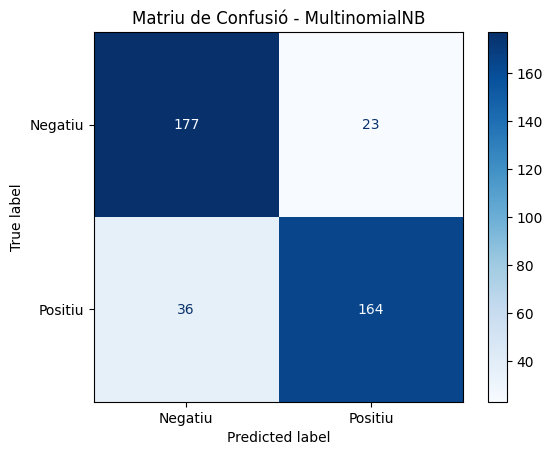

In [19]:
from sklearn.naive_bayes import MultinomialNB

grid_nb = GridSearchCV(MultinomialNB(), {"alpha": [1.0, 2.0, 5.0, 10.0]}, cv=10, scoring='accuracy', n_jobs=-1)
grid_nb.fit(X_train, y_train)
nb_model = grid_nb.best_estimator_

y_train_pred_nb = nb_model.predict(X_train)
y_test_pred_nb = nb_model.predict(X_test)

print("\n\033[1mMultinomialNB\033[0m")
print("\033[1mMillors paràmetres:\033[0m", grid_nb.best_params_)
print(f"\033[1mAccuracy TRAIN:\033[0m {accuracy_score(y_train, y_train_pred_nb):.4f}")
print(f"\033[1mAccuracy TEST:\033[0m {accuracy_score(y_test, y_test_pred_nb):.4f}")
print("\n")
print(classification_report(y_test, y_test_pred_nb, target_names=["Negatiu", "Positiu"]))

# Matriu de confusió
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_nb, display_labels=["Negatiu", "Positiu"], cmap="Blues")
plt.title("Matriu de Confusió - MultinomialNB")
plt.grid(False)
plt.show()

# ROC
y_proba_nb = nb_model.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
auc_nb = auc(fpr_nb, tpr_nb)


#### **2. Random Forest**

Per aquest model, hem volgut controlar la profunditat dels arbres (`max_depth`) i quantitat mínima de mostres per fer particions (`min_samples_split`), ja que si no es limita bé, Random Forest pot sobreajustar-se fàcilment al conjunt d’entrenament.

```python
"n_estimators": [100], 
"max_depth": [5, 8, 10],
"min_samples_split": [10, 20, 30]
```

Amb aquests valors hem buscat un model que sigui prou flexible però que no aprengui massa els detalls concrets del train (per evitar overfitting).


RandomForest
Millors paràmetres: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy TRAIN: 0.9719
Accuracy TEST: 0.8125


              precision    recall  f1-score   support

     Negatiu       0.79      0.85      0.82       200
     Positiu       0.84      0.78      0.81       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



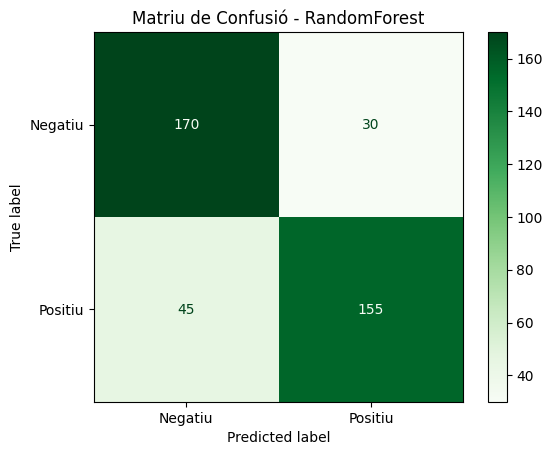

In [20]:
from sklearn.ensemble import RandomForestClassifier

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), {
    "n_estimators": [100],
    "max_depth": [5, 8, 10],
    "min_samples_split": [10, 20, 30]
}, cv=10, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
rf_model = grid_rf.best_estimator_

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

print("\n\033[1mRandomForest\033[0m")
print("\033[1mMillors paràmetres:\033[0m", grid_rf.best_params_)
print(f"\033[1mAccuracy TRAIN:\033[0m {accuracy_score(y_train, y_train_pred_rf):.4f}")
print(f"\033[1mAccuracy TEST:\033[0m {accuracy_score(y_test, y_test_pred_rf):.4f}")
print("\n")
print(classification_report(y_test, y_test_pred_rf, target_names=["Negatiu", "Positiu"]))

# Matriu de confusió
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_rf, display_labels=["Negatiu", "Positiu"], cmap="Greens")
plt.title("Matriu de Confusió - RandomForest")
plt.grid(False)
plt.show()

# ROC
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)


#### **3. Regressió Logística**

La regressió logística és un model simple però molt robust, i s’utilitza molt en classificació binària. L’únic hiperparàmetre que hem ajustat és `C`, que controla la regularització del model. Com més petit sigui `C`, més es penalitzen els pesos alts (és a dir, més regularització).

```python
"C": [0.001, 0.01, 0.1]
```

Aquesta gamma ens ha permès explorar diferents nivells de simplicitat del model. Hem utilitzat el solver `'liblinear'` perquè funciona molt bé amb conjunts petits i és compatible amb la regularització L1/L2.


LogisticRegression
Millors paràmetres: {'C': 0.01}
Accuracy TRAIN: 0.9406
Accuracy TEST: 0.8650


              precision    recall  f1-score   support

     Negatiu       0.84      0.91      0.87       200
     Positiu       0.90      0.82      0.86       200

    accuracy                           0.86       400
   macro avg       0.87      0.86      0.86       400
weighted avg       0.87      0.86      0.86       400



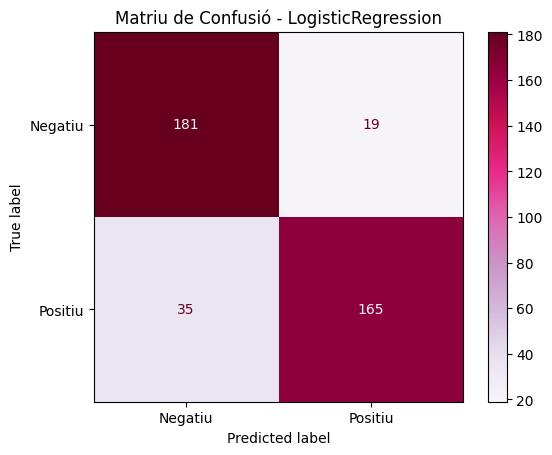

In [21]:
from sklearn.linear_model import LogisticRegression

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, solver='liblinear'), {
    "C": [0.001, 0.01, 0.1]
}, cv=10, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)
lr_model = grid_lr.best_estimator_

y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

print("\n\033[1mLogisticRegression\033[0m")
print("\033[1mMillors paràmetres:\033[0m", grid_lr.best_params_)
print(f"\033[1mAccuracy TRAIN\033[0m: {accuracy_score(y_train, y_train_pred_lr):.4f}")
print(f"\033[1mAccuracy TEST\033[0m: {accuracy_score(y_test, y_test_pred_lr):.4f}")
print("\n")
print(classification_report(y_test, y_test_pred_lr, target_names=["Negatiu", "Positiu"]))

# Matriu de confusió
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_lr, display_labels=["Negatiu", "Positiu"], cmap="PuRd")
plt.title("Matriu de Confusió - LogisticRegression")
plt.grid(False)
plt.show()

# ROC
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = auc(fpr_lr, tpr_lr)


#### **4. SVM (Support Vector Machine)**

Per l’SVM hem utilitzat un kernel lineal. Hem ajustat només el paràmetre `C`, que controla el marge del classificador.

```python
"C": [0.001, 0.005, 0.01, 0.1]
```

Com en el cas anterior, `C` ajuda a decidir si volem un marge més ample (més regularització) o més estricte.


SVC
Millors paràmetres: {'C': 0.005, 'kernel': 'linear'}
Accuracy TRAIN: 0.9363
Accuracy TEST: 0.8525
              precision    recall  f1-score   support

     Negatiu       0.82      0.90      0.86       200
     Positiu       0.89      0.81      0.85       200

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400



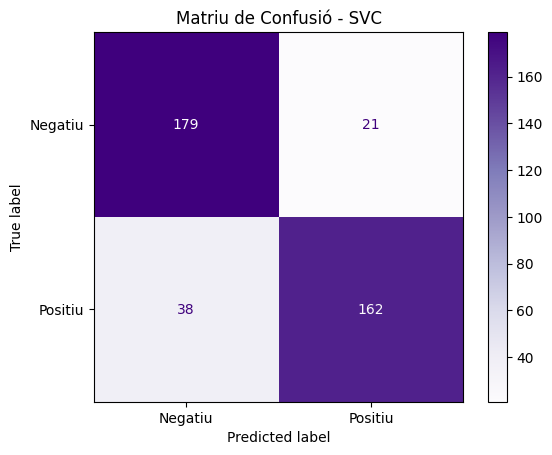

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

grid_svc = GridSearchCV(SVC(kernel='linear'), {
    "C": [0.001, 0.005, 0.01, 0.1]
}, cv=10, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train, y_train)

best_C = grid_svc.best_params_["C"]
svc_model = SVC(kernel='linear', C=best_C, probability=True)
svc_model.fit(X_train, y_train)

y_train_pred_svc = svc_model.predict(X_train)
y_test_pred_svc = svc_model.predict(X_test)

print("\n\033[1mSVC\033[0m")
print("\033[1mMillors paràmetres:\033[0m", {"C": best_C, "kernel": "linear"})
print(f"\033[1mAccuracy TRAIN\033[0m: {accuracy_score(y_train, y_train_pred_svc):.4f}")
print(f"\033[1mAccuracy TEST\033[0m: {accuracy_score(y_test, y_test_pred_svc):.4f}")
print(classification_report(y_test, y_test_pred_svc, target_names=["Negatiu", "Positiu"]))

# Matriu de confusió
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred_svc,
    display_labels=["Negatiu", "Positiu"],
    cmap='Purples'
)
plt.title("Matriu de Confusió - SVC")
plt.grid(False)
plt.show()

# ROC
y_proba_svc = svc_model.predict_proba(X_test)[:, 1]
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_proba_svc)
auc_svc = auc(fpr_svc, tpr_svc)

#### **Comparació de models amb la corba ROC**

Per visualitzar i comparar el rendiment dels diferents models, hem dibuixat la corba ROC de cadascun en el mateix gràfic. Aquesta corba mostra la relació entre la taxa de falsos positius i la de veritables positius. L’àrea sota la corba (AUC) ens proporciona una mesura clara de quin model distingeix millor entre positius i negatius.

Gràcies a això podem veure quin model generalitza millor i no només té bons resultats sobre les dades d’entrenament.

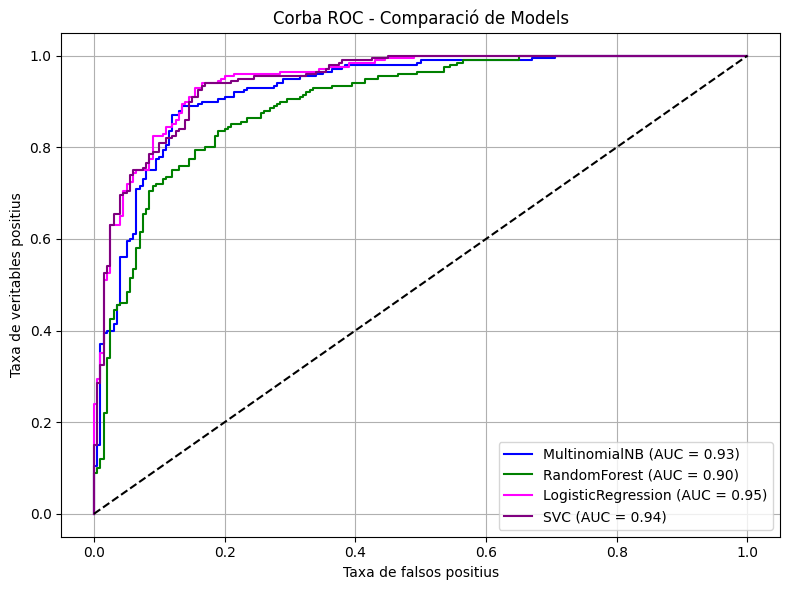

In [23]:
# Corba ROC de tots els models junts
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color='blue', label=f'MultinomialNB (AUC = {auc_nb:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', label=f'RandomForest (AUC = {auc_rf:.2f})')
plt.plot(fpr_lr, tpr_lr, color='fuchsia', label=f'LogisticRegression (AUC = {auc_lr:.2f})')
plt.plot(fpr_svc, tpr_svc, color='purple', label=f'SVC (AUC = {auc_svc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de falsos positius')
plt.ylabel('Taxa de veritables positius')
plt.title('Corba ROC - Comparació de Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


#### **Selecció del millor model**

In [24]:
# Diccionari amb resultats
resultats = {
    "Model": ["MultinomialNB", "RandomForest", "LogisticRegression", "SVC"],
    "Accuracy Train": [
        accuracy_score(y_train, y_train_pred_nb),
        accuracy_score(y_train, y_train_pred_rf),
        accuracy_score(y_train, y_train_pred_lr),
        accuracy_score(y_train, y_train_pred_svc)
    ],
    "Accuracy Test": [
        accuracy_score(y_test, y_test_pred_nb),
        accuracy_score(y_test, y_test_pred_rf),
        accuracy_score(y_test, y_test_pred_lr),
        accuracy_score(y_test, y_test_pred_svc)
    ],
    "Millors Paràmetres": [
        grid_nb.best_params_,
        grid_rf.best_params_,
        grid_lr.best_params_,
        grid_svc.best_params_
    ]
}

# Crear DataFrame i ordenar pel millor Accuracy de Test
df_resultats = pd.DataFrame(resultats)
df_resultats_ordenat = df_resultats.sort_values(by="Accuracy Test", ascending=False)

# Mostrar la taula
print("\n\033[1mComparativa final dels models:\033[0m\n")
print(df_resultats_ordenat.to_string(index=False))

# Mostrar el millor model
millor_model = df_resultats_ordenat.iloc[0]
print(f"\nEl millor model és \033[1m{millor_model['Model']}\033[0m amb una accuracy de test del {millor_model['Accuracy Test']:.4f}")
print(f"\033[1mMillors hiperparàmetres:\033[0m {millor_model['Millors Paràmetres']}")



Comparativa final dels models:

             Model  Accuracy Train  Accuracy Test                                              Millors Paràmetres
LogisticRegression        0.940625         0.8650                                                     {'C': 0.01}
     MultinomialNB        0.891875         0.8525                                                  {'alpha': 5.0}
               SVC        0.936250         0.8525                                                    {'C': 0.005}
      RandomForest        0.971875         0.8125 {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}

El millor model és LogisticRegression amb una accuracy de test del 0.8650
Millors hiperparàmetres: {'C': 0.01}


#### **Conclusió primera part**

Després d’entrenar i avaluar diversos models de classificació, hem comprovat que la **Regressió Logística** ha estat el model amb millor rendiment global. Ha obtingut la **millor accuracy de test (0.8650)** i també el **valor AUC més alt (0.95)** a la corba ROC, cosa que indica una molt bona capacitat de separació entre classes. 

Aquest resultat s’ha assolit amb el paràmetre `C = 0.01`, que ha proporcionat un bon equilibri entre regularització i ajust del model.

Altres models com **SVC** i **MultinomialNB** també han tingut un bon comportament, però lleugerament inferior. El model **Random Forest**, tot i tenir una alta precisió en l'entrenament, ha presentat **sobreajustament**, amb un rendiment inferior en el conjunt de test.


## **PART NO SUPERVISADA**

---

En aquesta segona part de la pràctica abordarem la classificació d’opinions des d’un enfocament **no supervisat**, on no disposem d’etiquetes prèvies per entrenar un model. El nostre objectiu serà determinar la polaritat (positiva o negativa) dels textos analitzant el significat de les paraules que contenen.

Per fer-ho, utilitzarem el **desambiguador Lesk** per obtenir el *synset* més probable de cada paraula, i a partir d’aquí extreurem els valors de **polaritat** mitjançant el diccionari **SentiWordNet**. Experimentarem amb diferents combinacions de categories gramaticals (adjectius, noms, verbs, adverbis) i estratègies d’agregació per obtenir una predicció final per a cada document.

Finalment, compararem els resultats d’aquesta aproximació amb els obtinguts en la part supervisada per analitzar les diferències de rendiment entre ambdós enfocaments.


In [25]:
%pip install requests

Note: you may need to restart the kernel to use updated packages.


In [26]:
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
from nltk.tokenize import word_tokenize
import numpy as np

nltk.download('sentiwordnet')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/paula/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [27]:
# Funció per obtenir el sentiment d'una paraula amb Lesk i SentiWordNet
def sentit_paraula_lesk(word, context, pos_tag):
    lesk_synset = lesk(context, word, pos=pos_tag)
    if lesk_synset:
        try:
            senti_synset = swn.senti_synset(lesk_synset.name())
            return senti_synset.pos_score(), senti_synset.neg_score()
        except:
            return None
    return None

### **Explicació del funcionament**

Per desenvolupar un classificador no supervisat de sentiment, hem seguit els passos següents:

1. **Desambiguació de paraules:**  hem utilitzat l’algorisme **Lesk** per determinar el significat (*synset*) de cada paraula dins del seu context, segons la seva categoria gramatical, ja sigui adjectiu, verb, nom o adverbi.

2. **Obtenció del sentiment:**  un cop tenim el *synset*, consultem **SentiWordNet** per obtenir-ne els valors de **positivitat i negativitat** associats.

3. **Ponderació i filtratge:**  inicialment, hem definit un sistema de ponderació assignant **pes només als adjectius**, amb l’objectiu d’analitzar si aquesta categoria tenia un paper especialment rellevant en la detecció de sentiment.  Posteriorment, hem creat nous models on hem **modificat les ponderacions** i hem afegit **altres categories gramaticals** (com noms, verbs i adverbis) per comparar-ne l’impacte en el rendiment global.  També hem descartat les paraules amb valors de sentiment molt baixos (`min_sentiment`) i hem aplicat un llindar (`threshold`) per evitar classificacions en casos amb polaritat poc clara.

4. **Classificació final del text:**  per cada document, hem sumat els valors positius i negatius de totes les paraules considerades. Si la diferència entre aquests valors supera el llindar establert, classifiquem el text com a **positiu** o **negatiu** segons quin predomini. Si no, apliquem una classificació per defecte basada en la polaritat més alta.



Resultats del model NO supervisat (SentiWordNet + Lesk millorada amb ponderació i filtrat)]
Accuracy Test: 0.6200
              precision    recall  f1-score   support

     Negatiu       0.64      0.54      0.59       200
     Positiu       0.60      0.70      0.65       200

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.62      0.62      0.62       400



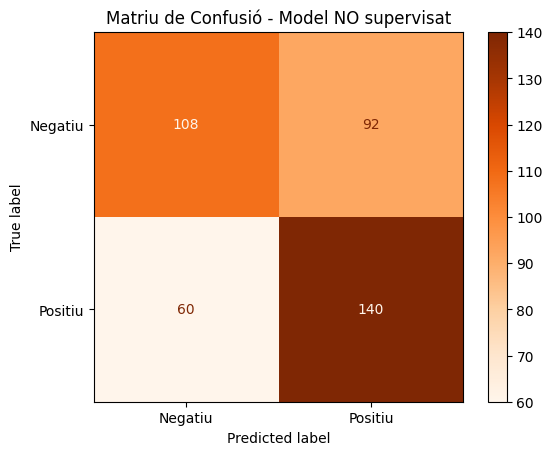

In [28]:
import numpy as np

# Diccionari de tags per conversió a WordNet i pesos especials per a pel·lícules
pos_tag_dict = {
    'JJ': ('a', 2.0), 'JJR': ('a', 2.0), 'JJS': ('a', 2.0),
}

# Funció per determinar la polaritat d'un text
def polaritat_text(text, categories=['a', 'r', 'n', 'v'], threshold=0.05, min_sentiment=0.2):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    pos_scores, neg_scores = [], []

    for word, tag in pos_tags:
        if tag in pos_tag_dict:
            wn_tag, weight = pos_tag_dict[tag]
            if wn_tag in categories:
                sentiment = sentit_paraula_lesk(word, tokens, wn_tag)
                if sentiment and (sentiment[0] >= min_sentiment or sentiment[1] >= min_sentiment):
                    pos_scores.append(sentiment[0] * weight)
                    neg_scores.append(sentiment[1] * weight)

    pos_avg = np.mean(pos_scores) if pos_scores else 0
    neg_avg = np.mean(neg_scores) if neg_scores else 0

    if abs(pos_avg - neg_avg) < threshold:
        return 0
    else:
        return 1 if pos_avg > neg_avg else 0

# Prediccions sobre el conjunt de test
categories_a_fer_servir = ['a', 'r', 'n', 'v']  # adjectius, adverbis, noms, verbs

# Calculem les prediccions pel conjunt de test
y_pred_unsup = [polaritat_text(text, categories=categories_a_fer_servir) for text in test_texts_clean]

# Obtenim accuracy i altres mètriques
print("\n\033[1mResultats del model NO supervisat (SentiWordNet + Lesk millorada amb ponderació i filtrat)\033[0m]")
print(f"\033[1mAccuracy Test:\033[0m {accuracy_score(y_test, y_pred_unsup):.4f}")
print(classification_report(y_test, y_pred_unsup, target_names=['Negatiu', 'Positiu']))

# Matriu de confusió
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_unsup, display_labels=["Negatiu", "Positiu"], cmap="Oranges")
plt.title("Matriu de Confusió - Model NO supervisat")
plt.grid(False)
plt.show()


Seguidament, hem definit una nova versió del model no supervisat, en la qual hem mantingut l’ús del desambiguador **Lesk** i el diccionari **SentiWordNet** per obtenir el sentiment de cada paraula. La principal novetat d'aquesta és la incorporació de **ponderacions específiques** per a diferents categories gramaticals,no sols els adjectius, amb l’objectiu de reflectir la seva importància relativa en l’expressió d’opinions. 

Les ponderacions assignades han estat:

- **Adjectius (`'a'`)**: pes 1.0  
  Considerem que els adjectius tenen un paper central en l’expressió d’opinions, però no necessàriament predominen numèricament en tots els textos.

- **Adverbis (`'r'`) i Verbs (`'v'`)**: pes 1.5  
  Hem incrementat el seu pes per valorar el seu impacte contextual en el to de la frase. Sovint matisen o intensifiquen el significat dels adjectius (p. ex. *"molt dolent"*, *"realment emocionant"*) o expressen accions amb càrrega emocional (*"va encantar-me"*, *"va decebre"*).

- **Noms (`'n'`)**: no ponderats explícitament (però es poden afegir si cal)  
  Els noms sovint són més neutres, però poden contenir informació rellevant quan es combinen amb altres paraules carregades emocionalment.

Mitjançant la definició d'aquets nou model, hem intentat analitzar la influències de la polaritat de cada categoria gramatical en la classificació obtinguda.



Resultats del model NO supervisat (SentiWordNet + Lesk millorada amb ponderació i filtrat)
Accuracy Test: 0.5950
              precision    recall  f1-score   support

     Negatiu       0.69      0.34      0.46       200
     Positiu       0.56      0.85      0.68       200

    accuracy                           0.59       400
   macro avg       0.63      0.59      0.57       400
weighted avg       0.63      0.59      0.57       400



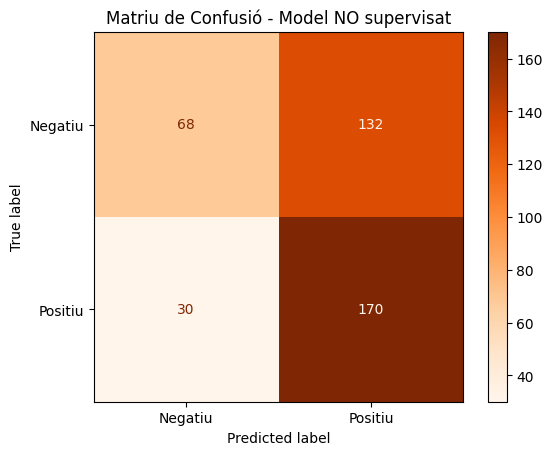

In [29]:
import numpy as np

# Diccionari de tags per conversió a WordNet i pesos especials per a pel·lícules
pos_tag_dict = {
    'JJ': ('a', 1.0), 'JJR': ('a', 1.0), 'JJS': ('a', 1.0),
    'RB': ('r', 1.5), 'RBR': ('r', 1.5), 'RBS': ('r', 1.5),
    'VB': ('v', 1.5), 'VBD': ('v', 1.5), 'VBG': ('v', 1.5), 'VBN': ('v', 1.5), 'VBP': ('v', 1.5), 'VBZ': ('v', 1.5)
}

# Funció per determinar la polaritat d'un text
def polaritat_text(text, categories=['a', 'r', 'n', 'v'], threshold=0.05, min_sentiment=0.2):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    pos_scores, neg_scores = [], []

    for word, tag in pos_tags:
        if tag in pos_tag_dict:
            wn_tag, weight = pos_tag_dict[tag]
            if wn_tag in categories:
                sentiment = sentit_paraula_lesk(word, tokens, wn_tag)
                if sentiment and (sentiment[0] >= min_sentiment or sentiment[1] >= min_sentiment):
                    pos_scores.append(sentiment[0] * weight)
                    neg_scores.append(sentiment[1] * weight)

    pos_avg = np.mean(pos_scores) if pos_scores else 0
    neg_avg = np.mean(neg_scores) if neg_scores else 0

    if abs(pos_avg - neg_avg) < threshold:
        return 0  
    else:
        return 1 if pos_avg > neg_avg else 0

# Prediccions sobre el conjunt de test
categories_a_fer_servir = ['a', 'r', 'n', 'v']  # adjectius, adverbis, noms, verbs

# Calculem les prediccions pel conjunt de test
y_pred_unsup = [polaritat_text(text, categories=categories_a_fer_servir) for text in test_texts_clean]

# Obtenim accuracy i altres mètriques
print("\n\033[1mResultats del model NO supervisat (SentiWordNet + Lesk millorada amb ponderació i filtrat)\033[0m")
print(f"\033[1mAccuracy Test:\033[0m {accuracy_score(y_test, y_pred_unsup):.4f}")
print(classification_report(y_test, y_pred_unsup, target_names=['Negatiu', 'Positiu']))

# Matriu de confusió
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_unsup, display_labels=["Negatiu", "Positiu"], cmap="Oranges")
plt.title("Matriu de Confusió - Model NO supervisat")
plt.grid(False)
plt.show()


Per últim, hem definit un **nou model** utilitzant les mateixes funcions i procés de classificació, però modificant **les ponderacions assignades a cada categoria gramatical**.

Les ponderacions assignades han estat:

- **Adjectius (`'a'`)**: pes 1.0  
  Considerem que els adjectius tenen un paper central en l’expressió d’opinions, però no necessàriament predominen numèricament en tots els textos.

- **Adverbis (`'r'`) i Verbs (`'v'`)**: pes 1.5  
  Hem incrementat el seu pes per valorar el seu impacte contextual en el to de la frase. Sovint matisen o intensifiquen el significat dels adjectius (p. ex. *"molt dolent"*, *"realment emocionant"*) o expressen accions amb càrrega emocional (*"va encantar-me"*, *"va decebre"*).

- **Noms (`'n'`)**: no ponderats explícitament (tot i que estan inclosos en l’anàlisi)  
  Els noms solen tenir una càrrega emocional més neutra, però poden aportar informació rellevant quan es combinen amb altres paraules amb sentiment.

Aquesta versió ens ha ajudat a explorar com canvia la classificació quan es dona més pes a categories que sovint passen desapercebudes en models més simples, i a comparar-ne els resultats amb les configuracions prèvies.




Resultats del model NO supervisat (SentiWordNet + Lesk millorada amb ponderació i filtrat)
Accuracy Test: 0.6250
              precision    recall  f1-score   support

     Negatiu       0.70      0.45      0.54       200
     Positiu       0.59      0.81      0.68       200

    accuracy                           0.62       400
   macro avg       0.64      0.62      0.61       400
weighted avg       0.64      0.62      0.61       400



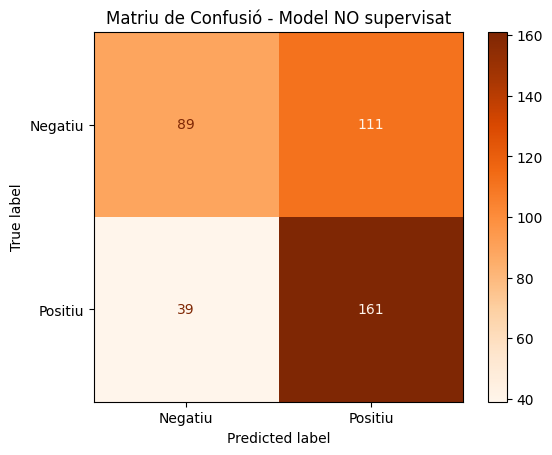

In [30]:
import numpy as np

# Diccionari de tags per conversió a WordNet i pesos especials per a pel·lícules
pos_tag_dict = {
    'NN': ('n', 1.0), 'NNS': ('n', 1.0), 'NNP': ('n', 1.0), 'NNPS': ('n', 1.0),
    'JJ': ('a', 2.0), 'JJR': ('a', 2.0), 'JJS': ('a', 2.0),
    'RB': ('r', 1.5), 'RBR': ('r', 1.5), 'RBS': ('r', 1.5),
    'VB': ('v', 1.5), 'VBD': ('v', 1.5), 'VBG': ('v', 1.5), 'VBN': ('v', 1.5), 'VBP': ('v', 1.5), 'VBZ': ('v', 1.5)
}

# Funció per determinar la polaritat d'un text complet
def polaritat_text(text, categories=['a', 'r', 'n', 'v'], threshold=0.05, min_sentiment=0.2):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    pos_scores, neg_scores = [], []

    for word, tag in pos_tags:
        if tag in pos_tag_dict:
            wn_tag, weight = pos_tag_dict[tag]
            if wn_tag in categories:
                sentiment = sentit_paraula_lesk(word, tokens, wn_tag)
                if sentiment and (sentiment[0] >= min_sentiment or sentiment[1] >= min_sentiment):
                    pos_scores.append(sentiment[0] * weight)
                    neg_scores.append(sentiment[1] * weight)

    pos_avg = np.mean(pos_scores) if pos_scores else 0
    neg_avg = np.mean(neg_scores) if neg_scores else 0

    if abs(pos_avg - neg_avg) < threshold:
        return 0
    else:
        return 1 if pos_avg > neg_avg else 0

# Prediccions sobre el conjunt de test
categories_a_fer_servir = ['a', 'r', 'n', 'v']  # adjectius, adverbis, noms, verbs

# Calculem les prediccions pel conjunt de test
y_pred_unsup = [polaritat_text(text, categories=categories_a_fer_servir) for text in test_texts_clean]

# Obtenim accuracy i altres mètriques
print("\n\033[1mResultats del model NO supervisat (SentiWordNet + Lesk millorada amb ponderació i filtrat)\033[0m")
print(f"\033[1mAccuracy Test:\033[0m {accuracy_score(y_test, y_pred_unsup):.4f}")
print(classification_report(y_test, y_pred_unsup, target_names=['Negatiu', 'Positiu']))

# Matriu de confusió
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_unsup, display_labels=["Negatiu", "Positiu"], cmap="Oranges")
plt.title("Matriu de Confusió - Model NO supervisat")
plt.grid(False)
plt.show()



Després de provar diverses configuracions del model no supervisat, el millor resultat s’ha obtingut amb **l’última versió** que incorpora ponderacions diferenciades per categoria gramatical.

Aquest model ha assolit una **accuracy de test del 0.6250**, millorant lleugerament respecte a versions anteriors. A més, ha destacat per un **alt recall en la classe positiva (0.81)**, tot i que amb un **recall més baix en la negativa (0.45)**.

Aquesta versió ha estat seleccionada com **la més adequada** per dur a terme la **comparativa amb els models supervisats**.

La manipulació dels pesos ens ha permès **ajustar el comportament del model** i observar de manera directa **la influència i importància de cada categoria gramatical** (adjectius, adverbis, verbs i noms) en el càlcul del sentiment. Aquest procés d’experimentació ens ha ajudat a entendre millor com les decisions de disseny poden afectar el rendiment d’un model no supervisat.


## **COMPARACIÓ MODEL SUPERVISAT I NO SUPERVISAT**


Comparació amb el millor model supervisat
Millor model supervisat (Accuracy Test): 0.8650 (LogisticRegression)
Model no supervisat (Accuracy Test): 0.6250


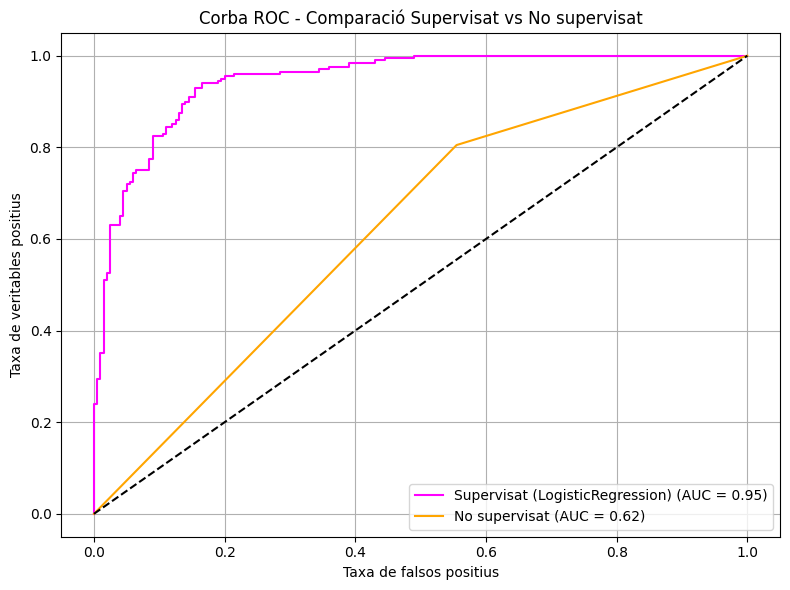

In [31]:
best_models = {
    "MultinomialNB": nb_model,
    "RandomForest": rf_model,
    "LogisticRegression": lr_model,
    "SVC": svc_model
}

# Comparació amb el millor model supervisat
print("\n\033[1mComparació amb el millor model supervisat\033[0m")
print(f"\033[1mMillor model supervisat (Accuracy Test):\033[0m {millor_model['Accuracy Test']:.4f} ({millor_model['Model']})")
print(f"\033[1mModel no supervisat (Accuracy Test):\033[0m {accuracy_score(y_test, y_pred_unsup):.4f}")

# Corba ROC comparativa
plt.figure(figsize=(8, 6))

# Supervisat
fpr_sup, tpr_sup, _ = roc_curve(y_test, best_models[millor_model['Model']].predict_proba(X_test)[:, 1])
auc_sup = auc(fpr_sup, tpr_sup)
plt.plot(fpr_sup, tpr_sup, label=f"Supervisat ({millor_model['Model']}) (AUC = {auc_sup:.2f})", color="fuchsia")

# No supervisat
fpr_unsup, tpr_unsup, _ = roc_curve(y_test, y_pred_unsup)
auc_unsup = auc(fpr_unsup, tpr_unsup)
plt.plot(fpr_unsup, tpr_unsup, label=f"No supervisat (AUC = {auc_unsup:.2f})", color="orange")

plt.plot([0, 1], [0, 1], 'k--')  # línia diagonal
plt.xlabel('Taxa de falsos positius')
plt.ylabel('Taxa de veritables positius')
plt.title('Corba ROC - Comparació Supervisat vs No supervisat')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

La comparació entre el millor model supervisat (Regressió Logística) i el millor model no supervisat mostra una diferència clara de rendiment.

El model **supervisat** ha assolit una **accuracy del 86.5%** i un **AUC de 0.95**, destacant per la seva gran capacitat de separació entre classes i precisió en les prediccions. Per contra, el model **no supervisat** ha aconseguit una **accuracy del 62.5%** i un **AUC de 0.62**, amb resultats molt més modestos.

Tot i això, cal remarcar que el model no supervisat no ha requerit dades etiquetades, i mitjançant l’ajust dels pesos i les estratègies de filtratge, hem pogut millorar-ne el comportament. Aquesta comparació ens ha permès veure clarament els **avantatges de l’aprenentatge supervisat** en tasques de classificació, però també el potencial de models no supervisats quan les dades etiquetades no estan disponibles.

El model supervisat (Regressió Logística) ha superat clarament el model no supervisat tant en **accuracy** com en **capacitat de discriminació (AUC)** i aquestes són les petites diferencies que mostren tots dos models:

- **Accés a dades etiquetades**: el model supervisat s'entrena amb exemples reals ja classificats, cosa que li permet aprendre patrons específics i ajustar-se millor a les característiques dels textos. El model no supervisat, en canvi, no disposa d’aquesta informació i ha de basar-se únicament en recursos externs com SentiWordNet.

- **Aprenentatge basat en dades reals**: el model supervisat pot adaptar-se a com s’expressa el sentiment en el conjunt concret de dades, mentre que el model no supervisat depèn de valoracions genèriques de paraules, que poden no captar bé el context.

- **Capacitat de generalització**: tot i el risc d’*overfitting*, els models supervisats, si es validen correctament, poden generalitzar millor perquè aprenen d’exemples reals i representatius.

En resum, el model supervisat és superior perquè pot aprendre directament dels casos reals, mentre que el no supervisat parteix de suposicions més generals sobre el llenguatge.



## **ANÀLISI DELS ERRORS**

---

Per complementar la comparativa, hem fet una **breu anàlisi dels errors de classificació** amb l’objectiu de detectar si existeixen **característiques comunes** entre els casos mal classificats, tant en el model supervisat com en el no supervisat.

Em realitzat aquest anàlisis amb l'obejctiu d'identificar **limitacions compartides** i oportunitats de millora, especialment pel que fa al tractament del context i a la desambiguació semàntica.


In [32]:
y_pred_sup = best_models["LogisticRegression"].predict(X_test)

def analisi_errors_comparat(test_texts, y_test, y_pred_sup, y_pred_unsup):
    total = len(y_test)
    
    errors_sup = sum([1 for true, pred in zip(y_test, y_pred_sup) if true != pred])
    errors_unsup = sum([1 for true, pred in zip(y_test, y_pred_unsup) if true != pred])
    
    print("\033[1mAnàlisi d'errors comparatiu\033[0m")
    print("-" * 50)
    print(f"\033[1mTotal de textos:\033[0m {total}")
    print(f"\033[1mErrors model supervisat:\033[0m {errors_sup}")
    print(f"\033[1mErrors model no supervisat:\033[0m {errors_unsup}")

analisi_errors_comparat(test_texts, y_test, y_pred_sup, y_pred_unsup)

Anàlisi d'errors comparatiu
--------------------------------------------------
Total de textos: 400
Errors model supervisat: 54
Errors model no supervisat: 150


In [33]:
def mostra_errors_comuns(test_texts, y_test, y_pred_sup, y_pred_unsup):
    print("\n\033[1mTextos mal classificats per TOTS DOS models:\033[0m")
    errors_ambdós = [
        (i, text, y, sup, unsup)
        for i, (text, y, sup, unsup) in enumerate(zip(test_texts, y_test, y_pred_sup, y_pred_unsup))
        if sup != y and unsup != y
    ]
    
    if not errors_ambdós:
        print("\033[1mCap text mal classificat pels dos models a la vegada.\033[1m")
    else:
        for i, text, y, sup, unsup in errors_ambdós:
            print(f"\n📄 #{i+1}")
            print(f"\033[1mText:\033[0m {text[:300]}...")
            print(f"\033[1mReal:\033[0m {'Positiu' if y==1 else 'Negatiu'} | Supervisat: {'Positiu' if sup==1 else 'Negatiu'} | No Supervisat: {'Positiu' if unsup==1 else 'Negatiu'}")

mostra_errors_comuns(test_texts_clean, y_test, y_pred_sup, y_pred_unsup)


Textos mal classificats per TOTS DOS models:

📄 #7
Text: base novel set joseph conrad victory spin tale pair lover heyst william dafoe alma irene jacob seek refuge heyst isolated island however idyllic world begin crumble upon arrival mr jones sam neil martin ricardo rufus sewell servant pedro graziano marcelli come steal heyst rumour plunder novel largel...
Real: Negatiu | Supervisat: Positiu | No Supervisat: Positiu

📄 #23
Text: moviemaking lot like general manager nfl team post salary cap era get know allocate resource every dollar spend free agent defensive tackle one less dollar spend linebacker safety center nfl lead team like detroit lion boast superstar run back huge contract field five guy name herb block movie end f...
Real: Positiu | Supervisat: Negatiu | No Supervisat: Negatiu

📄 #29
Text: reasonable human would must admit occasionally befuddle certain thing befuddle fight club sometimes favorite film pan critic achieve critical success much later sometimes much ten twenty

**Textos mal classificats per tots dos models – Anàlisi d’errors comuns**

Hem detectat un conjunt de textos que han estat mal classificats tant pel model supervisat com pel no supervisat. Aquesta coincidència en l’error ens indica que existeixen **característiques textuals específiques** que dificulten la classificació, independentment de l’enfocament utilitzat.

Alguns factors comuns observats en aquests textos són:

- **Llenguatge ambigu o neutre**: molts textos no expressen opinions clares o directes, sinó que barregen elements positius i negatius, fan servir ironia o mantenen un to narratiu més informatiu que valoratiu.

- **Construccions llargues i complexes**: en diversos casos, els textos són extensos i amb frases complicades, cosa que pot dificultar tant la detecció de sentiments concrets (model no supervisat) com l'extracció de patrons clars (model supervisat).

- **Expressions poc habituals o estil elaborat**: alguns textos utilitzen vocabulari ric, figures retòriques o metàfores, que poden escapar als recursos com SentiWordNet o no haver estat ben representats durant l’entrenament del model supervisat.

- **Opinions implícites**: en diversos exemples, la valoració de la pel·lícula s’intueix pel context o el to, però no s’expressa explícitament amb paraules típicament associades al sentiment (com *"fantàstic"*, *"horrible"*, *"decebedor"*, etc.).

Aquest anàlisi mostra que existeixen **zones complicades o amb limitacions** dins la classificació de sentiments on cap model aconsegueix interpretar correctament el contingut. Això ens mostra la importància de millorar la comprensió contextual i semàntica en futurs models.


In [34]:
def mostra_sup_ok_unsup_ko(test_texts, y_test, y_pred_sup, y_pred_unsup):
    print("\n\033[1mTextos classificats bé pel SUPERVISAT però malament pel NO SUPERVISAT:\033[0m")
    casos = [
        (i, text, y, sup, unsup)
        for i, (text, y, sup, unsup) in enumerate(zip(test_texts, y_test, y_pred_sup, y_pred_unsup))
        if sup == y and unsup != y
    ]
    
    if not casos:
        print("\033[1mCap text amb aquest cas.\033[0m")
    else:
        for i, text, y, sup, unsup in casos:
            print(f"\n📄 #{i+1}")
            print(f"\033[1mText:\033[0m {text[:300]}...")
            print(f"\033[1mReal:\033[0m {'Positiu' if y==1 else 'Negatiu'} | Supervisat: {'Positiu' if sup==1 else 'Negatiu'} | No Supervisat: {'Positiu' if unsup==1 else 'Negatiu'}")

mostra_sup_ok_unsup_ko(test_texts_clean, y_test, y_pred_sup, y_pred_unsup)


Textos classificats bé pel SUPERVISAT però malament pel NO SUPERVISAT:

📄 #9
Text: late lead female character julia stile state great fear artificial conversation boyfriend freddie prinze jr irony statement lose audience member yet walk fallen asleep otherwise give pathetic attempt romantic comedy film multi million dollar testament everything artificial fill character motivation ...
Real: Negatiu | Supervisat: Negatiu | No Supervisat: Positiu

📄 #12
Text: highly intelligent life form completely electronic nature beam onto russian science vessel well point movie stray become decent original movie simply become predictable sci fi thriller anyhow life form take control computer russian vessel start create highly advanced robot help gruesome task extermi...
Real: Negatiu | Supervisat: Negatiu | No Supervisat: Positiu

📄 #16
Text: plot rich psychiatrist great home life get cute daughter kidnap bad guy want extract information mind one nutty patient course patient cooperative doctor hour c

**Textos classificats bé pel model supervisat però malament pel no supervisat**

Hem identificat diversos textos que el model **supervisat** ha classificat correctament mentre que el **no supervisat** ha fallat. Aquests textos ens permet destacar algunes de les limitacions específiques del model no supervisat i, alhora, entendre per què el supervisat és més efectiu en aquests casos.

Algunes observacions generals sobre aquests textos:

- **Context complex o irònic**: molts textos utilitzen ironia, sarcasme o crítiques indirectes que no es reflecteixen en paraules amb polaritat clara. El model supervisat, entrenat amb exemples similars, és capaç de captar aquest tipus de construcció. El no supervisat, en canvi, depèn exclusivament del significat individual de les paraules i sol confondre’s.

- **Crítiques negatives expressades amb llenguatge neutre o sofisticat**: en molts casos, el sentiment negatiu no es manifesta amb paraules clarament negatives, sinó a través del to general o de l’estructura del discurs. Això fa que el model no supervisat, que no entén el context global, assigni una polaritat incorrecta.

- **Ambigüitat semàntica**: El model no supervisat pot interpretar com a positives algunes paraules que, en context, formen part d’una crítica. El model supervisat, en canvi, ha après de casos similars i pot reconèixer patrons de frase que porten a una millor interpretació.

Aquest patró d’errors reforça la idea que els models **supervisats poden aprendre matisos i estructures més complexes**, mentre que els models **no supervisats són molt més sensibles a l’elecció i al pes de les paraules individuals**, sense entendre el missatge global del text.


In [35]:
def mostra_unsup_ok_sup_ko(test_texts, y_test, y_pred_sup, y_pred_unsup):
    print("\n\033[1mTextos classificats bé pel NO SUPERVISAT però malament pel SUPERVISAT:\033[0m")
    casos = [
        (i, text, y, sup, unsup)
        for i, (text, y, sup, unsup) in enumerate(zip(test_texts, y_test, y_pred_sup, y_pred_unsup))
        if sup != y and unsup == y
    ]
    
    if not casos:
        print("\033[1mCap text amb aquest cas.\033[0m")
    else:
        for i, text, y, sup, unsup in casos:
            print(f"\n📄 #{i+1}")
            print(f"\033[1mText:\033[0m {text[:300]}...")
            print(f"\033[1mReal:\033[0m {'Positiu' if y==1 else 'Negatiu'} | Supervisat: {'Positiu' if sup==1 else 'Negatiu'} | No Supervisat: {'Positiu' if unsup==1 else 'Negatiu'}")

mostra_unsup_ok_sup_ko(test_texts_clean, y_test, y_pred_sup, y_pred_unsup)


Textos classificats bé pel NO SUPERVISAT però malament pel SUPERVISAT:

📄 #11
Text: china turn table national guide ask question america guess expect sort political question instead dumfounded mind america wife mother law get along well assure china certain true would ask even china people seem problem relate law perhaps life difficult relationship arise family suddenly artificiall...
Real: Negatiu | Supervisat: Positiu | No Supervisat: Negatiu

📄 #17
Text: billy crystal reappears yet another high concept comedy try infuse life get bogged sentimentality lack sophistication sammy billy crystal struggle agent end rope separate wife serena kathleen quinlan last serious client low budget film shoot romania turn bad luck sammy wreck car mysteriously save gi...
Real: Negatiu | Supervisat: Positiu | No Supervisat: Negatiu

📄 #48
Text: usually movie something soiled rug big lebowski new offering creator critical hit fargo say least wildly entertain originality always strong trait coen brother

**Textos classificats bé pel model NO supervisat però malament pel supervisat**

Tot i que en general el model supervisat ha obtingut millors resultats, també hem detectat alguns casos on el model **no supervisat ha estat més encertat**. Aquests exemples ens ajuden a entendre en quines situacions l’enfocament no supervisat pot tenir un avantatge.

Els patrons que hem observat són:

- **Presència de paraules amb polaritat clara**: En molts d’aquests textos hi ha adjectius, verbs o expressions clarament positives o negatives. El model no supervisat, basat en SentiWordNet, aprofita aquestes puntuacions per prendre decisions més encertades en aquests casos.

- **Errors d’aprenentatge del model supervisat**: El model supervisat pot haver classificat erròniament aquests textos perquè durant l’entrenament no ha vist exemples prou similars, o bé perquè ha après patrons erronis (overfitting).

- **Valoració més directa i menys contextual**: En alguns casos, el model no supervisat pot funcionar millor quan el sentiment està expressat de forma simple i clara, sense necessitat d'interpretar construccions lingüístiques complexes.

Aquest anàlisi posa en relleu que, malgrat les seves limitacions, els models no supervisats poden resultar útils en entorns amb menys dades, i que una **combinació híbrida** de mètodes podria millorar encara més els resultats en futurs treballs.


## **CONCLUSIÓ GENERAL**

---

En aquest treball hem desenvolupat i comparat dos enfocaments per a la detecció automàtica d'opinions en crítiques de pel·lícules, un de supervisat i un de no supervisat.

Pel que fa al **model supervisat**, hem provat diversos algoritmes d'aprenentatge automàtic (com Logistic Regression, SVM, Random Forest i Naive Bayes), i hem ajustat els hiperparàmetres mitjançant validació creuada. El model que ha obtingut els **millors resultats** ha estat la **regressió logística**, amb una *accuracy* del **86.5%** i un AUC de **0.95**. Aquest model ha estat capaç de capturar patrons complexos en les dades gràcies a l'entrenament amb exemples etiquetats.

En canvi, el model **no supervisat**, basat en **SentiWordNet i desambiguació semàntica amb l’algorisme de Lesk**, no requeria dades etiquetades. Tot i que els seus resultats han estat inferiors (*accuracy* del **62.5%**, AUC de **0.62**), hem pogut observar que **ajustant les ponderacions dels tipus de paraules** (adjectius, adverbis, verbs...) hem millorat notablement la classificació respecte a una versió inicial més simple. Això demostra la rellevància d’analitzar el pes i la influència de les categories gramaticals en la detecció de sentiments.

L’anàlisi d’errors ens ha permès detectar situacions habituals de classificació incorrecta, com ara textos amb ironia, estructura narrativa o valoracions implícites. També hem observat que hi ha **casos on el model no supervisat ha superat el supervisat**, generalment quan el llenguatge utilitzat era més directe o contenia paraules amb polaritat molt clara.

Finalment, la realització d'aquest treball i la implementació de l'anàlisis dels errors, ens ha permès concloure els models **supervisats són més potents i precisos** quan disposem d’un conjunt d’entrenament representatiu. No obstant això, els **models no supervisats poden ser útils en contextos amb escassetat de dades etiquetades**, i ofereixen una base interessant per combinar amb mètodes híbrids en futurs estudis.
